In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("streamflow.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print("Missing values:\n", df.isna().sum())


Missing values:
 Unnamed: 0      0
Year            0
Month           0
Day             0
Q (m3/s)      588
dtype: int64


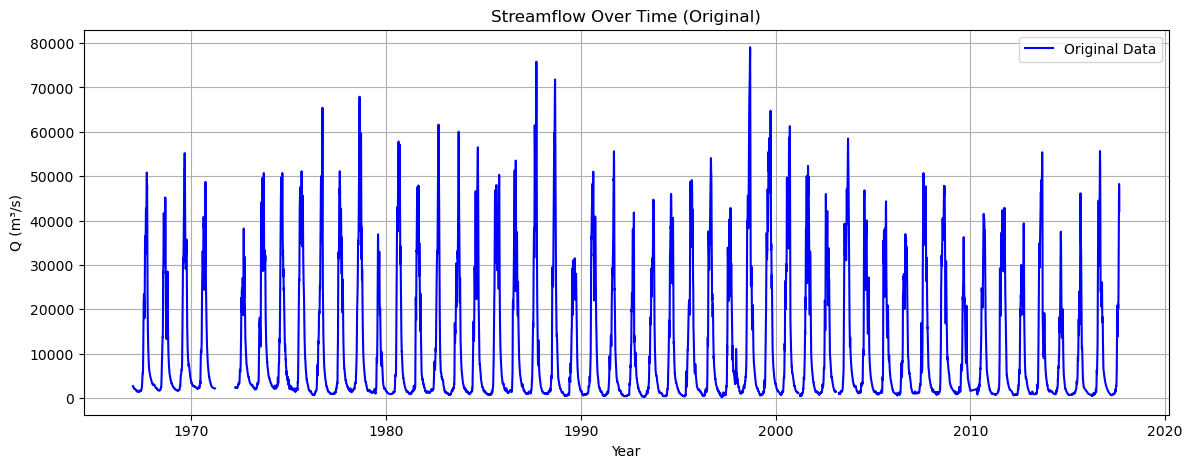

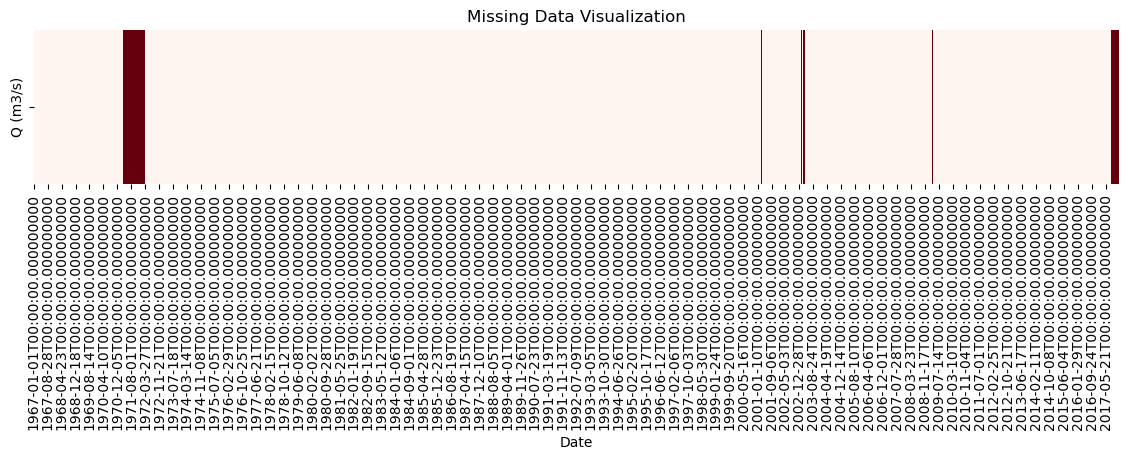

In [55]:
plt.figure(figsize=(14, 5))
plt.plot(df['Q (m3/s)'], label='Original Data', color='blue')
plt.title('Streamflow Over Time (Original)')
plt.xlabel('Year')
plt.ylabel('Q (m³/s)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 2))
sns.heatmap(df[['Q (m3/s)']].isna().T, cmap='Reds', cbar=False)
plt.title('Missing Data Visualization')
plt.xlabel('Date')
plt.show()


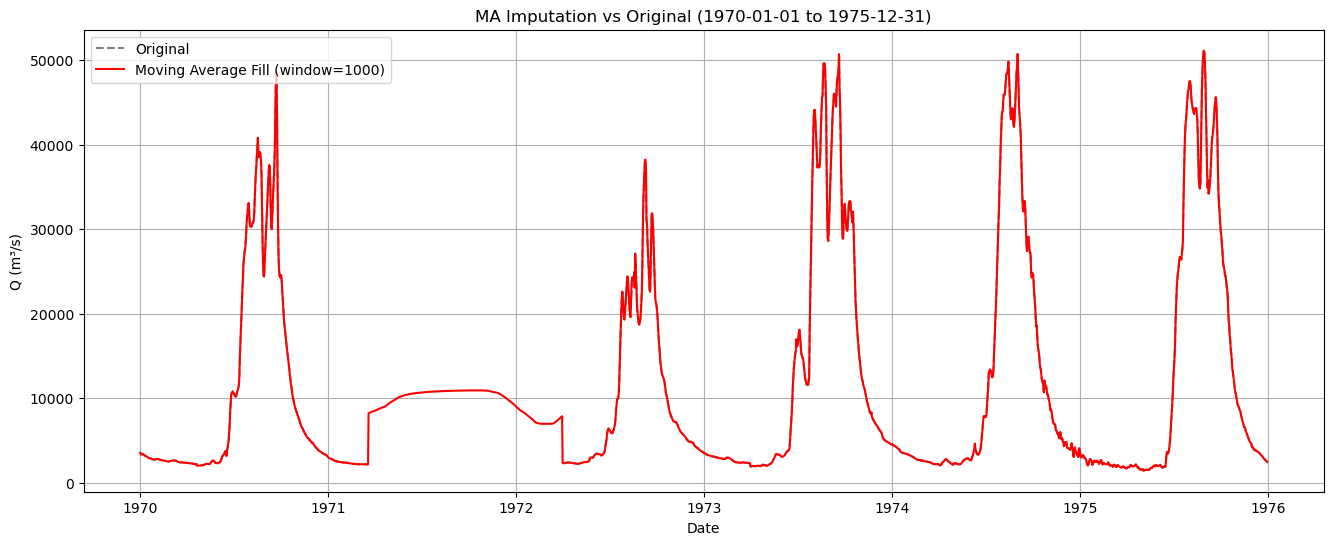

In [56]:
window_size = 1000

df_ma = df.copy()
df_ma['Q (m3/s)'] = df_ma['Q (m3/s)'].fillna(
    df_ma['Q (m3/s)'].rolling(window=window_size, min_periods=1, center=True).mean()
)

start_date = '1970-01-01'
end_date = '1975-12-31'

plt.figure(figsize=(16,6))
plt.plot(df['Q (m3/s)'].loc[start_date:end_date], label='Original', color='gray', linestyle='--')
plt.plot(df_ma['Q (m3/s)'].loc[start_date:end_date], label=f'Moving Average Fill (window={window_size})', color='red')
plt.title(f'MA Imputation vs Original ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Q (m³/s)')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
import pandas as pd

df.index = pd.to_datetime(df.index)
print("Total missing values before filling:", df['Q (m3/s)'].isna().sum())


Total missing values before filling: 588


#Seasonal-Trend Decomposition Imputation

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_decomp = df.copy()
df_decomp['Q (m3/s)'] = df_decomp['Q (m3/s)'].interpolate()

daily = df_decomp['Q (m3/s)'].asfreq('D')

decomp = seasonal_decompose(daily, model='additive', period=365)

filled_A = decomp.trend + decomp.seasonal
df_filled_A = df.copy()
df_filled_A['Q (m3/s)'] = df_filled_A['Q (m3/s)'].fillna(filled_A)

print("Remaining NaN after Option A:", df_filled_A['Q (m3/s)'].isna().sum())


Remaining NaN after Option A: 127


#Climatological Imputation

In [59]:
df['DOY'] = df.index.dayofyear

mean_pattern = df.groupby('DOY')['Q (m3/s)'].mean()

df_filled_B = df.copy()

missing_mask = df_filled_B['Q (m3/s)'].isna()
df_filled_B.loc[missing_mask, 'Q (m3/s)'] = [
    mean_pattern.get(ts.timetuple().tm_yday, None) for ts in df_filled_B.index[missing_mask]
]

print("Remaining NaN after Option B:", df_filled_B['Q (m3/s)'].isna().sum())


Remaining NaN after Option B: 0


If X(t) is missing, fill it with the average of the same calendar day from other years.

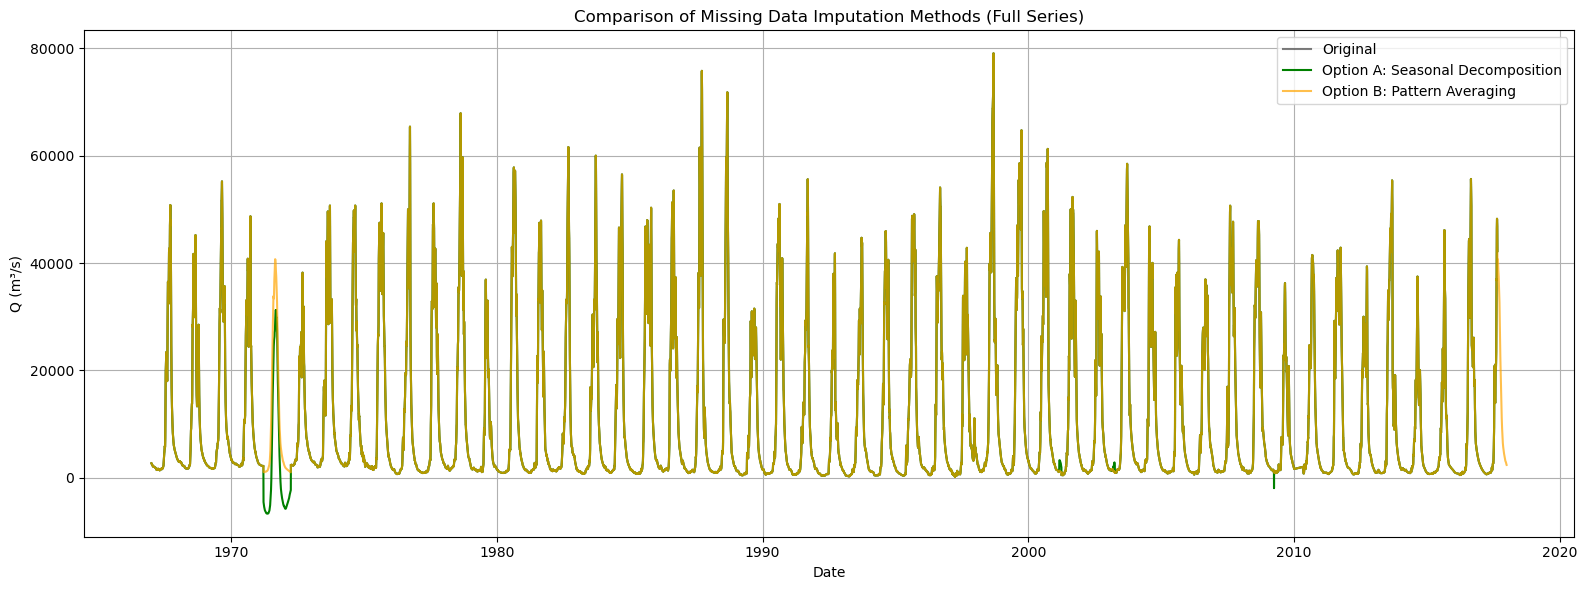

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot(df['Q (m3/s)'], color='black', alpha=0.5, label='Original')
plt.plot(df_filled_A['Q (m3/s)'], color='green', label='Option A: Seasonal Decomposition')
plt.plot(df_filled_B['Q (m3/s)'], color='orange', label='Option B: Pattern Averaging', alpha=0.7)
plt.title('Comparison of Missing Data Imputation Methods (Full Series)')
plt.xlabel('Date')
plt.ylabel('Q (m³/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_zoom_on_missing(df_original, df_filled_A, df_filled_B, gap_index=0, window_before=30, window_after=30):

    missing_mask = df_original['Q (m3/s)'].isna()
    gaps = []
    current_gap = []

    for date, missing in zip(df_original.index, missing_mask):
        if missing:
            current_gap.append(date)
        elif current_gap:
            gaps.append((current_gap[0], current_gap[-1]))
            current_gap = []
    if current_gap:
        gaps.append((current_gap[0], current_gap[-1]))

    if gap_index >= len(gaps):
        print(f"There are only {len(gaps)} missing segments. gap_index={gap_index} is out of range.")
        return

    start_gap, end_gap = gaps[gap_index]
    zoom_start = start_gap - pd.Timedelta(days=window_before)
    zoom_end = end_gap + pd.Timedelta(days=window_after)

    original_segment = df_original['Q (m3/s)'].loc[zoom_start:zoom_end].dropna()

    plt.figure(figsize=(14, 6))

    plt.plot(
        original_segment.index,
        original_segment.values,
        color='black',
        marker='*',
        linestyle='None',
        markersize=8,
        label='Original (Observed)'
    )

    plt.plot(df_filled_A['Q (m3/s)'].loc[zoom_start:zoom_end], color='green', label='Option A (Decomposition)')
    plt.plot(df_filled_B['Q (m3/s)'].loc[zoom_start:zoom_end], color='blue', label='Option B (Pattern)')

    plt.axvspan(start_gap, end_gap, color='red', alpha=0.15, label='Missing Period')

    plt.title(f"Zoom on Missing Gap #{gap_index+1} ({start_gap.date()} → {end_gap.date()})")
    plt.xlabel('Date')
    plt.ylabel('Q (m³/s)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


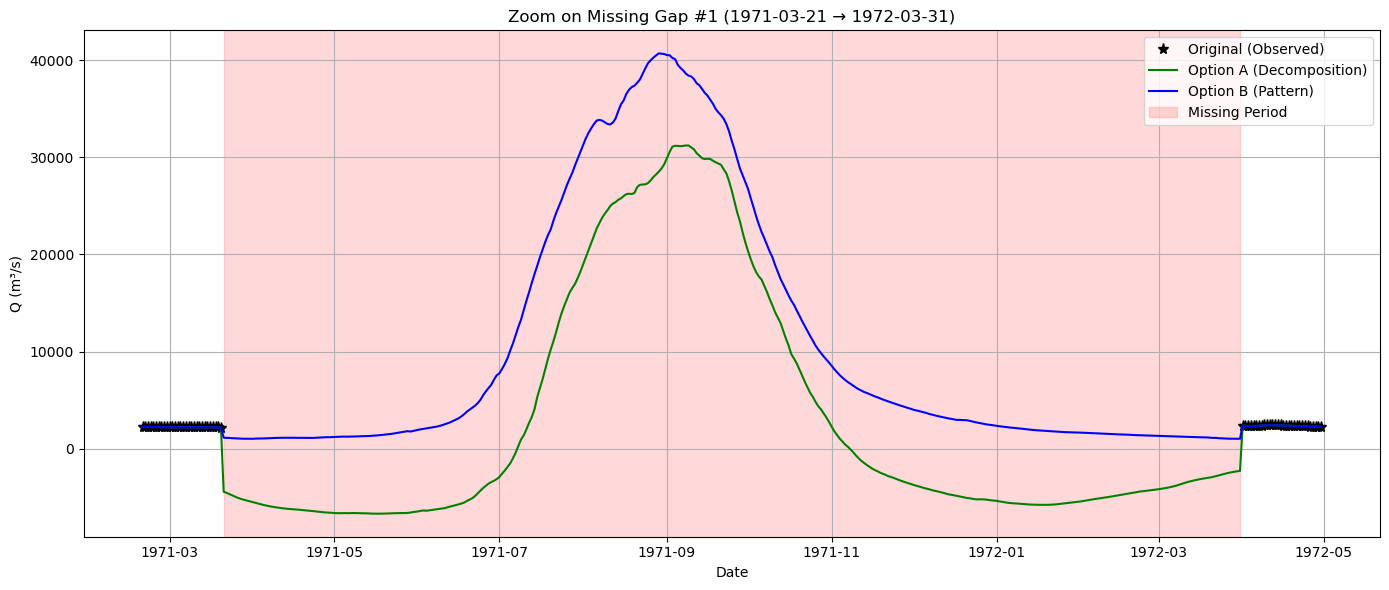

In [66]:
plot_zoom_on_missing(df, df_filled_A, df_filled_B, gap_index=0)
#Change the gap_index to visualize different missing segments

In [63]:
df_filled_B = df_filled_B.drop(columns=['DOY'])


In [64]:
df_filled_B.to_csv('streamflow_filled_ARIMA.csv', index=True)